Iteration: 100, ErrorVor: 330.90857577576924, ErrorT: 13.986859757966585, ErrorPsi: 0.005243877241988218
Iteration: 200, ErrorVor: 216.56208441815815, ErrorT: 7.166055098580054, ErrorPsi: 0.005360347668079305
Iteration: 300, ErrorVor: 188.72892468672316, ErrorT: 5.066615949302959, ErrorPsi: 0.005330835735481591
Iteration: 400, ErrorVor: 160.6208714573398, ErrorT: 3.6961016670505527, ErrorPsi: 0.005086595756126348
Iteration: 500, ErrorVor: 135.69410443042563, ErrorT: 2.787381537792019, ErrorPsi: 0.005005238662765631
Iteration: 600, ErrorVor: 114.77015150095738, ErrorT: 2.2759263154507092, ErrorPsi: 0.004813435661626526
Iteration: 700, ErrorVor: 97.50430197984363, ErrorT: 1.8929355620381665, ErrorPsi: 0.004692384679832913
Iteration: 800, ErrorVor: 83.34449115918578, ErrorT: 1.5957555324164046, ErrorPsi: 0.004568554395966578
Iteration: 900, ErrorVor: 71.71892782486518, ErrorT: 1.3613805779930526, ErrorPsi: 0.004415935747349699
Iteration: 1000, ErrorVor: 62.07750377128091, ErrorT: 1.187606

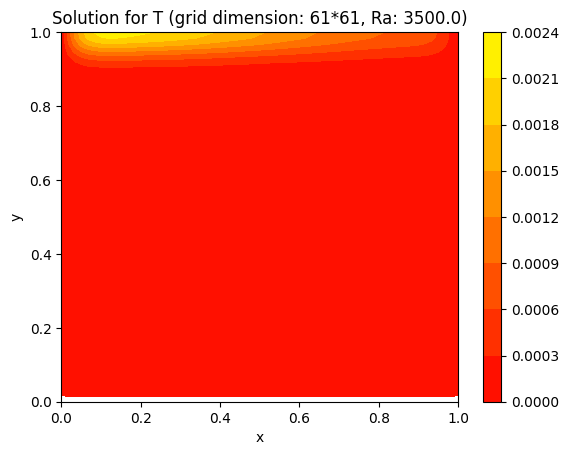

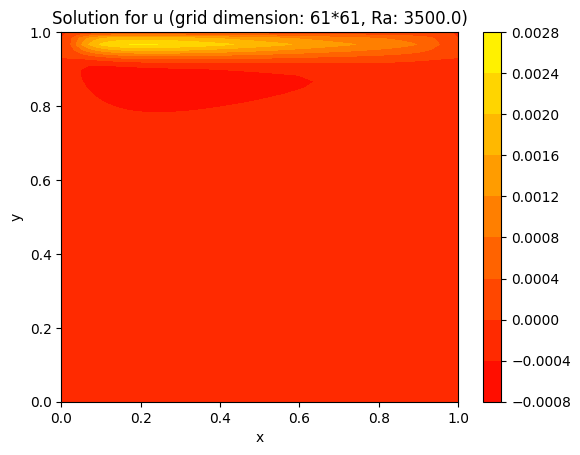

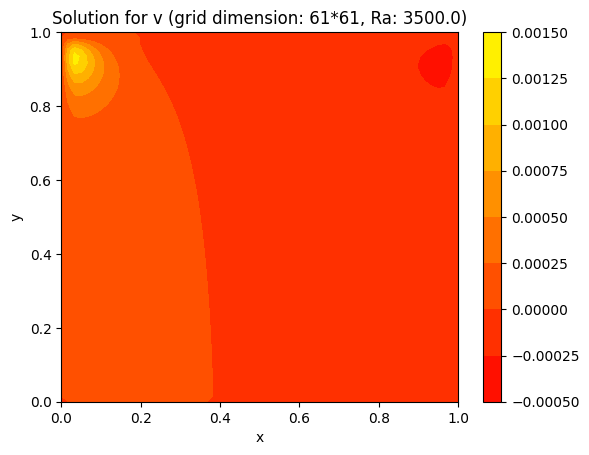

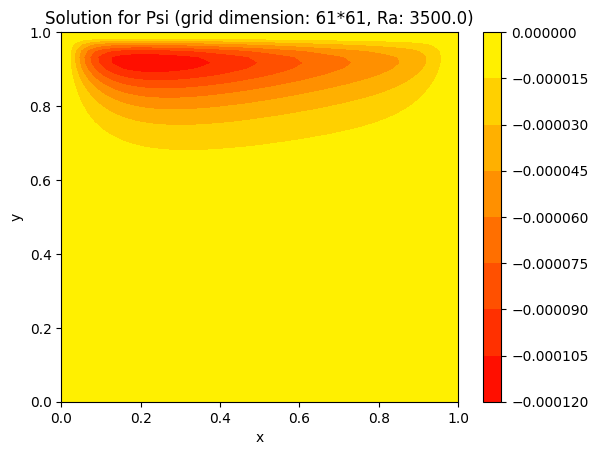

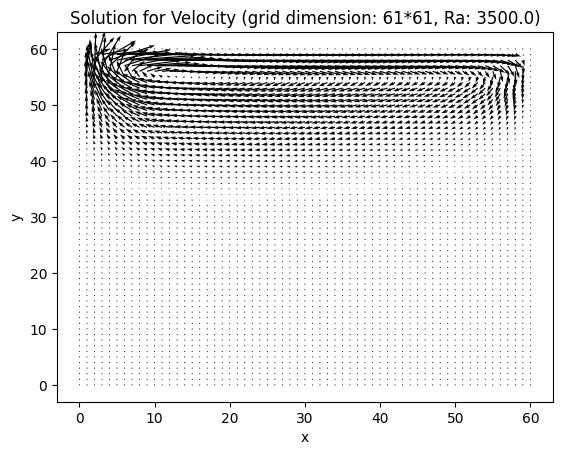

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# ================================
# Define all functions
# ================================

def solve_RVor(M, N, Pr, Ra, Vor, T, u, v, dx, dy):
    RVor = np.zeros_like(Vor)
    for i in range(1, M-1):
        for j in range(1, N-1):
            dVordx2 = (Vor[i+1,j]-2*Vor[i,j]+Vor[i-1,j]) / dx**2
            dVordy2 = (Vor[i,j+1]-2*Vor[i,j]+Vor[i,j-1]) / dy**2
            dTdx = (T[i+1,j]-T[i-1,j]) / (2*dx)
            dVordx1 = (Vor[i+1,j]-Vor[i-1,j]) / (2*dx)
            dVordy1 = (Vor[i,j+1]-Vor[i,j-1]) / (2*dy)
            RVor[i,j] = Pr * (dVordx2 + dVordy2) + Pr * Ra * dTdx - u[i,j] * dVordx1 - v[i,j] * dVordy1
    return RVor

def solve_Vor(M, N, Vor, RVor, dt):
    Vor[1:M-1,1:N-1] += RVor[1:M-1,1:N-1] * dt
    return Vor

def solve_QT(M, N, T, u, v, dx, dy):
    QT = np.zeros_like(T)
    for i in range(1, N-1):
        for j in range(1, M-1):
            dTdx2 = (T[i+1,j]-2*T[i,j]+T[i-1,j]) / dx**2
            dTdy2 = (T[i,j+1]-2*T[i,j]+T[i,j-1]) / dy**2
            dTdx = (T[i+1,j]-T[i-1,j]) / (2*dx)
            dTdy = (T[i,j+1]-T[i,j-1]) / (2*dy)
            QT[i,j] = dTdx2 + dTdy2 - (u[i,j]*dTdx + v[i,j]*dTdy)
    return QT

def solve_T(M, N, T, QT, dt):
    T[1:N-1,1:M-1] += QT[1:N-1,1:M-1] * dt
    return T

def solve_SPsi(M, N, Vor, Psi, dx, dy):
    SPsi = np.zeros_like(Psi)
    for i in range(2, M-2):
        for j in range(2, N-2):
            dPsidx2 = (Psi[i+1,j]-2*Psi[i,j]+Psi[i-1,j]) / dx**2
            dPsidy2 = (Psi[i,j+1]-2*Psi[i,j]+Psi[i,j-1]) / dy**2
            SPsi[i,j] = Vor[i,j] - (dPsidx2 + dPsidy2)
    return SPsi

def solve_Psi(M, N, Psi, SPsi, dx, dy):
    beta = 0.4
    b_W = 1/dx**2
    b_S = 1/dy**2
    b_P = -2 * (b_W + b_S)
    Psi[2:M-2,2:N-2] += SPsi[2:M-2,2:N-2] * beta / b_P
    return Psi

def BC_Psi(M, N, Psi):
    Psi[1:M-1,1] = 0.25 * Psi[1:M-1,2]
    Psi[1:M-1,N-2] = 0.25 * Psi[1:M-1,N-3]
    Psi[1,1:N-1] = 0.25 * Psi[2,1:N-1]
    Psi[M-2,1:N-1] = 0.25 * Psi[M-3,1:N-1]
    return Psi

def BC_T(M, N, T):
    T[0,:] = (4*T[1,:] - T[2,:]) / 3
    T[N-1,:] = (4*T[N-2,:] - T[N-3,:]) / 3
    return T

def BC_Vor(M, N, Vor, Psi, dx, dy):
    Vor[:,0] = (3/dx**2)*Psi[:,1] - 0.5*Vor[:,1]
    Vor[:,M-1] = (3/dx**2)*Psi[:,M-2] - 0.5*Vor[:,M-2]
    Vor[0,:] = (3/dy**2)*Psi[1,:] - 0.5*Vor[1,:]
    Vor[N-1,:] = (3/dy**2)*Psi[N-2,:] - 0.5*Vor[N-2,:]
    return Vor

def compute_velocity(M, N, u, v, dx, dy, Psi, T, dTdx, dTdy):
    u[:,[0,-1]] = 0
    v[:,[0,-1]] = 0
    u[[0,-1],:] = 0
    v[[0,-1],:] = 0
    # dTdy[[0,-1],:] = 0
    for j in range(1,M-1):
        for i in range(1,N-1):
            u[j,i] = (Psi[j+1,i] - Psi[j-1,i]) / (2*dy)
            v[j,i] = (Psi[j,i-1] - Psi[j,i+1]) / (2*dx)
            # dTdx[j,i] = (T[j,i+1]-T[j,i-1]) / (2*dx)
            # dTdy[j,i] = (T[j+1,i]-T[j-1,i]) / (2*dy)
    return u, v, dTdx, dTdy

def compute_err(RVor, SPsi, QT, M, N):
    errVor = np.max(np.abs(RVor[1:M-1,1:N-1]))
    errPsi = np.max(np.abs(SPsi[2:M-2,2:N-2]))
    errT = np.max(np.abs(QT[1:M-1,1:N-1]))
    return errVor, errPsi, errT

def compute_Nu_vel(M, N, u, v, dTdy):
    u_max = np.max(u[:,N//2])
    u_idx = np.argmax(u[:,N//2])
    v_max = np.max(v[M//2,:])
    v_idx = np.argmax(v[M//2,:])
    Nu_0 = np.mean(np.abs(dTdy[1,1:N-1]))
    Nu_half = np.mean(np.abs(dTdy[N//2,1:N-1]))
    Nu_max = np.max(np.abs(dTdy[1,1:N-1]))
    Numax_idx = np.argmax(np.abs(dTdy[1,1:N-1]))
    return u_max, v_max, Nu_0, Nu_half, Nu_max, u_idx, v_idx, Numax_idx

# 1) Setting iteration and convergence criteria
itr = 1
epsilon1 = 1e-3
epsilon2 = 1e-4
epsilon3 = 1e-3
dt = 0.000001  # time step size

Pr = 0.7    # Prandtl number
Ra = 3.5e3  # Rayleigh number

# 2) Mesh generation
N = 61
M = 61

dx = 1 / (N-1)
dy = 1 / (M-1)

# 3) Set up initial flow field
u = np.zeros((M, N))
v = np.zeros((M, N))
T = np.zeros((M, N))
Psi = np.zeros((M, N))
Vor = np.zeros((M, N))
dTdx = np.zeros((M, N))
dTdy = np.zeros((M, N))
RVor = np.zeros((M, N))
SPsi = np.zeros((M, N))
QT = np.zeros((M, N))

# 4) Set temperature boundary condition
for i in range(N):
    T[M-1, i] = 0.5 * np.cos(np.pi * i * dx) + 1  # Lower boundary

# 5) Enter loop to solve
while True:
    RVor = solve_RVor(M, N, Pr, Ra, Vor, T, u, v, dx, dy)
    Vor = solve_Vor(M, N, Vor, RVor, dt)

    QT = solve_QT(M, N, T, u, v, dx, dy)
    T = solve_T(M, N, T, QT, dt)

    SPsi = solve_SPsi(M, N, Vor, Psi, dx, dy)
    Psi = solve_Psi(M, N, Psi, SPsi, dx, dy)

    Psi = BC_Psi(M, N, Psi)
    T = BC_T(M, N, T)
    Vor = BC_Vor(M, N, Vor, Psi, dx, dy)

    u, v, dTdx, dTdy = compute_velocity(M, N, u, v, dx, dy, Psi, T, dTdx, dTdy)
    errVor, errPsi, errT = compute_err(RVor, SPsi, QT, M, N)

    if itr % 100 == 0:
        print(f"Iteration: {itr}, ErrorVor: {errVor}, ErrorT: {errT}, ErrorPsi: {errPsi}")

    if itr == 1000:
        break

    itr += 1

# 6) Output parameters
# u_max, v_max, Nu_0, Nu_half, Nu_max, u_idx, v_idx, Numax_idx = compute_Nu_vel(M, N, u, v, dTdy)

# print(f"The maximum value of u on the vertical mid-plane is {u_max} at y = {u_idx}.")
# print(f"The maximum value of v on the horizontal mid-plane is {v_max} at x = {v_idx}.")
# print(f"The average Nusselt number on the horizontal boundary (y=0) is {Nu_0}")
# print(f"The average Nusselt number on the horizontal mid-plane (y=0.5) is {Nu_half}")
# print(f"The maximum Nusselt number on the horizontal boundary (y=0) is {Nu_max} at x = {Numax_idx}.")

# 7) Plot contours
X, Y = np.linspace(0, 1, N), np.linspace(0, 1, M)
X, Y = np.meshgrid(X, Y)

plt.figure()
plt.contourf(X, Y, T, cmap='autumn')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Solution for T (grid dimension: {N}*{M}, Ra: {Ra})")
plt.show()

plt.figure()
plt.contourf(X, Y, u, cmap='autumn')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Solution for u (grid dimension: {N}*{M}, Ra: {Ra})")
plt.show()

plt.figure()
plt.contourf(X, Y, v, cmap='autumn')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Solution for v (grid dimension: {N}*{M}, Ra: {Ra})")
plt.show()

plt.figure()
plt.contourf(X, Y, Psi, cmap='autumn')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Solution for Psi (grid dimension: {N}*{M}, Ra: {Ra})")
plt.show()

plt.figure()
plt.quiver(u, v)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Solution for Velocity (grid dimension: {N}*{M}, Ra: {Ra})")
plt.show()
